<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget file.weasoft.com/images.zip
# !wget file.weasoft.com/summary.csv
# !unzip images.zip
# !wget file.weasoft.com/eff_s_3_19010.pt -O eff_s_1_8010.pt
# !git clone https://github.com/suanfaxiaohuo/SwinOCSR.git
# !pip install focal_loss_torch wandb
# !pip3 install deepsmiles yacs tqdm

In [ ]:
import sys
import os
import argparse
from tqdm import tqdm
import deepsmiles
from typing import Any, cast, Callable, List, Tuple, Union
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [ ]:
import sys
sys.path.append("./SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")
from pre_transformer import Transformer
class FocalLossModelInference:
    """
    Inference Class
    """
    def __init__(self):
        # Load dictionary that maps tokens to integers
        word_map_path = './SwinOCSR/Data/500wan/500wan_shuffle_DeepSMILES_word_map'
        self.word_map = torch.load(word_map_path)
        self.inv_word_map = {v: k for k, v in self.word_map.items()}

        # Define device, load models and weights
        self.dev = "cuda" if torch.cuda.is_available() else "cpu"
        # self.args, config = self.get_inference_config()
        # self.encoder = build_model(config, tag=False)
        self.decoder = self.build_decoder()
        # self.load_checkpoint("./swin_transform_focalloss.pth")
        self.decoder = self.decoder.to(self.dev).eval()
        # self.encoder = self.encoder.to(self.dev).eval()

    def load_checkpoint(self, checkpoint_path):
        """
        Load checkpoint and update encoder and decoder accordingly

        Args:
            checkpoint_path (str): path of checkpoint file
        """
        print(f"=====> {checkpoint_path} <=====")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        # encoder_msg = self.encoder.load_state_dict(checkpoint['encoder'],
        #                                            strict=False)
        decoder_msg = self.decoder.load_state_dict(checkpoint['decoder'],
                                                   strict=False)
        # print(f"Encoder: {encoder_msg}")
        print(f"Decoder: {decoder_msg}")
        del checkpoint
        torch.cuda.empty_cache()

    def build_decoder(self):
        """
        This method builds the Transformer decoder and returns it
        """
        self.decoder_dim = 256  # dimension of decoder RNN
        self.ff_dim = 2048
        self.num_head = 8
        self.dropout = 0.1
        self.encoder_num_layer = 6
        self.decoder_num_layer = 6
        self.max_len = 277
        self.decoder_lr = 5e-4
        self.best_acc = 0.
        return Transformer(dim=self.decoder_dim,
                           ff_dim=self.ff_dim,
                           num_head=self.num_head,
                           encoder_num_layer=self.encoder_num_layer,
                           decoder_num_layer=self.decoder_num_layer,
                           vocab_size=len(self.word_map),
                           max_len=self.max_len,
                           drop_rate=self.dropout,
                           tag=False)
transformer_ = FocalLossModelInference()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import base64
import pandas as pd
import os

In [ ]:
import sys
sys.path.append("./SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [ ]:
eff = torchvision.models.efficientnet_v2_s(weights='DEFAULT')
mynet = eff.features
class ImageEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.eff = mynet.to(device)
    self.projection = torch.nn.Linear(768,256).to(device)
  def forward(self, images):
    features = self.eff(images)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    return self.projection(features)
class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in, xmask):
    image_feature = self.encoder(image)
    out = self.decoder(text_in, image_feature, x_mask=xmask)
    return out

In [ ]:
mod = torch.load("eff_s_1_8010.pt", map_location=device) #it is model not dict

In [ ]:
def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch, maxlen

In [ ]:
torch.topk(torch.tensor([1,2,3,4]),2)

torch.return_types.topk(
values=tensor([4, 3]),
indices=tensor([3, 2]))

In [ ]:
def triangle_mask(size):
    mask = 1- np.triu(np.ones((1, size, size)),k=1).astype('uint8')
    mask = torch.autograd.Variable(torch.from_numpy(mask))
    return mask

In [ ]:
!wget file.weasoft.com/reverse.map

--2024-02-06 06:12:30--  http://file.weasoft.com/reverse.map
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 875
Saving to: ‘reverse.map.2’

reverse.map.2       100%[===================>]     875  --.-KB/s    in 0s      

2024-02-06 06:12:30 (136 MB/s) - ‘reverse.map.2’ saved [875/875]



In [ ]:
reversed_word_map = {}
import json
with open("reverse.map","r") as f:
  reversed_word_map = json.loads(f.read())

In [ ]:
from focal_loss.focal_loss import FocalLoss
m = torch.nn.Softmax(dim=-1)
lf = FocalLoss(gamma=2, ignore_index=0)#torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction="none")
def loss_fn(pred, truth):
  pred = m(pred)
  l = lf(pred, truth)
  return l

In [ ]:
def mask_acc(pred, truth):
    pred = torch.argmax(pred, -1)
    mask = truth != 0
    match_case = truth == pred
    return torch.sum(mask*match_case)/torch.sum(mask)

In [ ]:
BATCH_SIZE = 1

In [ ]:
import pandas as pd
molecules_rows = pd.read_csv("summary.csv")

In [ ]:
print("\n".join(list(set([i.split("_")[0] for i in os.listdir("images")]))))

8148
24250
11202
8078
286
10952
71601
25975
22497934
175854
12361
11241
7962
11429
18302
18632
8100
11508
7977
8072
2724488
6562
13556
7901
18150
7851
13589
220010
7966
16565
439846
11203
18175
11240
11182
68424
7745
13855
91563
21159
751
11250
753
13202
757
19463
14480
12250
15274
78344
11536
225936
12417
638066
11523
6587
8902


In [140]:
import random
converter = deepsmiles.Converter(rings=True, branches=True)
cids = list(molecules_rows["cid"])
train_cids = [i for i in cids if not i in [286, 6587, 6562, 11203]]
# val_cids = ["a"]
val_cids = [286, 6587, 6562, 11203]

train_names = [i for i in os.listdir("./images") if int(i.split("_")[0]) in train_cids]
val_names = [i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cids]
from PIL import ImageOps

def getitem(index, train=True):
  ti = []
  to = []
  imgs = []

  # train=FalseTAMADE WEISM TRAIN = FALSE!!!guaibude bunengfanhua shouzhima ghuainbbude val namehao zuibakouke azhiqianweismkeyile? jiushiyingweimeiyouyongnamesle
  names = train_names if train else val_names
  start = index*16
  end =  (index+1)*16
  end = len(names) if end>len(names) else end
  # print(start, end)
  for i in range(start, end):


    name = random.choice([i for i in os.listdir("./images")])

    img = Image.open(f"images/{name}").convert("RGB")
    if train:
      img = img.rotate(random.choice([0,90,180,270]), expand=0).resize((400,400))
      if random.random()>0.5:
        img = ImageOps.flip(img)
      if random.random()>0.5:
        img = ImageOps.mirror(img)
      img.crop((random.random()*30,random.random()*30,400-random.random()*30,400-random.random()*30))
    img = np.array(img.resize((400,400)), dtype="float32")
    if train:
      # img[:,:,0] *= random.random()*0.2+0.9
      img[:,:,1] *= random.random()*0.1+0.9
      img[:,:,2] *= random.random()*0.1+0.9
      img[:,:,:] *= random.random()*0.1+0.8
    img = torch.tensor(np.array(img)).permute(2, 0, 1).to(torch.float32).to(device)
    # if train:
    #   # img+=torch.rand((3,400,400)).to(device)*50
    #   for _ in range(30):
    #     x,y = int(random.random()*380),int(random.random()*380)
    #     img[:,x:x+20, y:y+20] = torch.rand((3,20,20))*250
#  guoranhaishiyaoqudizokunduzikoue
    # if train:
      # img*=torch.round(torch.tanh(5*torch.rand((3,400,400)))).to(device)
    # print(name)
    # print(converte//r.encode(molecules_rows[molecules_rows["cid"]==int(name.split("_")[0])]["canonicalsmiles"].item()))
    smiles = [transformer_.word_map[i] for i in converter.encode(molecules_rows[molecules_rows["cid"]==int(name.split("_")[0])]["canonicalsmiles"].item())]
    ti.append([77] + smiles)
    to.append(smiles + [78])
    imgs.append(img)
  return torch.stack(imgs), ti, to


In [ ]:
torch.stack([torch.tensor([1,2]) for i in range(10)])

tensor([[1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2]])

In [ ]:
# print("\n".join([str(i) for i in df["cid"].unique()]))

In [ ]:
def val():
  global mod, val_names
  np.random.shuffle(val_names)
  running_loss = 0
  mod = mod.train(False)  #forget to use =
  # ids = os.listdir("images")[:10]

  valacc = []
  start_index = i
  image, text_in, text_out = getitem(0, train=False)

  image = image.to(device)
  text_out = pad_pack(text_out)[0].to(device)
  padded_x = pad_pack(text_in)

  xmask = triangle_mask(padded_x[1]).to(device)
  text_in = padded_x[0].to(device)

  outputs = mod(image, text_in, xmask)
  loss = loss_fn(outputs, text_out)



  running_loss += loss.item()
  valacc.append(mask_acc(outputs.detach(), text_out).item())
  mod = mod.train(True)
  return running_loss, np.mean(valacc)


In [ ]:
mod = torch.load("eff_s_1_8010.pt", map_location=device) #it is model not dict

In [ ]:
for i in mod.decoder.parameters():
  i.require_grad = False
for i in mod.encoder.eff[6:].parameters():
  i.require_grad = False

# for layers in mod.encoder.eff[:4]:
#   for i in layers.parameters():
#     i.require_grad = False

In [ ]:
torch.manual_seed(0)

In [ ]:
# 都改回来了还是一样好？ 没有，开始变差了，数据增强有用？还是冻结 shetou mingbaileshizuihoudeyouzaid

In [139]:
def train(lr, T0, epoch, forzen, reload=False):
  split=1
  global mod
  # lr = lr*split #oh why learning rate*4 this is why it trains much better, still need nigher learning rate zuibagankouke zhege haizaizheli a a banbenwanquanluanle
  if reload:
    mod = torch.load("eff_s_1_8010.pt", map_location=device) #it is model not dict
    if forzen:
      for i in mod.parameters():
        i.require_grad = True
      for i in mod.decoder.parameters():
        i.require_grad = False
      for i in mod.encoder.parameters():
        i.require_grad = False
      for i in mod.encoder.eff[-3:].parameters():
        i.require_grad = True
      for i in mod.encoder.projection.parameters(): #forgot about this forgrt to set oiit to false just checked history this is why
        i.require_grad = True
  losses = []
  access = []
  val_acc = []
  optimizer = torch.optim.AdamW(
    mod.parameters(),
    lr=lr)
  import pylab
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T0)
  running_loss = 0
  for epoch in range(epoch):
    np.random.shuffle(train_names)
    mod.train(True)
    # ids = [i for i in os.listdir("images") if not i.startswith("638066")]
    # ids = os.listdir("images")[10:]
    # np.random.shuffle(ids)
    for i in range(len(train_names)//(16*split)):#why set this and it be better or is it learning rate? it lower faster? hyper-parameter kunduzikouke gaile lenoslistdir dao trainnames cjiuhuichaoguo100?wtfmeiyouyunxingduzikunk
      if i==None:
        continue
      start_index = i
      image, text_in, text_out = getitem(i, True)

      image = image.to(device) #mutli process cannot use cuda so moved here
      # image = torch.permute(image, (0, 3, 1, 2))
      text_out = pad_pack(text_out)[0].to(device)
      padded_x = pad_pack(text_in)

      xmask = triangle_mask(padded_x[1]).to(device)
      text_in = padded_x[0].to(device)

      optimizer.zero_grad()
      outputs = mod(image, text_in, xmask)
      #loss = loss_fn(outputs, text_outi) guaibude yyixiazinamegao
      loss = loss_fn(outputs, text_out)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      losses.append(loss.item())
      access.append(mask_acc(outputs.detach(), text_out))

    val_acc.append(val()[1])
    print(val_acc)
    scheduler.step()
    # print(optimizer.param_groups[0]["lr"])
  pylab.plot([i.item() for i in access], label="Train")
  pylab.plot(np.arange(1, len(val_acc)+1)*(len(access)/len(val_acc)),val_acc,label="Val")
  pylab.legend()
  pylab.show()
  pylab.savefig(f"{lr}_{T0}_{epoch}.png")
  return mod

In [ ]:
reversed_word_map_={}
for i in reversed_word_map.keys():
  reversed_word_map_[int(i)] = reversed_word_map[i]

In [ ]:
np_map = np.array(list(reversed_word_map_.values()))
for i in reversed_word_map_.keys():
  np_map[i] = reversed_word_map_[i]

In [ ]:
def top_k_2d(m, k):
  values, indices = torch.topk(m.flatten(), k)
  return indices//m.shape[1], indices%m.shape[1]
  # return indices//m.shape[0]-1, indices%m.shape[1]

In [ ]:
top_k_2d(torch.tensor([[0,1,4,12],
                       [0,10,0,0]]),2)

(tensor([0, 1]), tensor([3, 1]))

In [ ]:
#shetouexguaibudexianzaihaole xianzaishizhenggewenjianjiadounaquxunlianle  kunexhaishiyoufenkaide touuuyun

[0.9615384340286255]
[0.9615384340286255, 0.9825581312179565]
[0.9615384340286255, 0.9825581312179565, 0.984375]


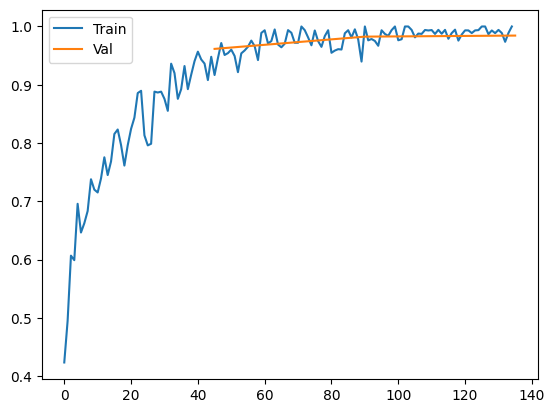

<Figure size 640x480 with 0 Axes>

In [141]:
mod = train(0.0005, 4, 3,  True, reload=True)#duzikunhuxi xiaobatch size lianggejiuhaole

In [ ]:
mod = torch.load("drive/MyDrive/CNO", map_location=device)

In [142]:
t = 1

class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, images, text_in_, max_len, beam): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
    with torch.no_grad():
      image_feature = []
      for i in images:
        image_feature.append(self.encoder(i))
      image_feature = torch.stack(image_feature)
      # print(image_feature.shape)
      image_feature = image_feature.squeeze(1)
      mem = gen.decoder.encoder(gen.decoder.encoder_dim(image_feature))
      mem = torch.mean(mem, dim=0)
      mem = mem.unsqueeze(0).repeat_interleave(beam, dim=0)
      # return mem
      top_n = torch.tensor(text_in_)
      top_n_p = torch.tensor([0]).to(device)
      for i in range(max_len):
        padded_text, l = pad_pack(top_n)
        padded_text = padded_text.to(device)
        # print(padded_text)
        out = torch.nn.functional.softmax(self.decoder.decoder(padded_text, mem, x_mask=triangle_mask(l).to(device))[:,-1,:].squeeze(dim=1), dim=1)
        # pylab.plot(out[0])
        # pylab.show()
        if i>1:
          for j in range(beam):
            if top_n[j][-1]==78:
              out[j]=torch.zeros(79)
              out[j][78]=1

        tmp_n = top_n_p.repeat((79,1)).T+torch.log(out)#forgot softymax
        x, y = top_k_2d(tmp_n, beam)
        new_top_n = []
        new_top_n_p = []
        # print(tmp_n)
        for j in range(beam):
          new_top_n.append(torch.cat((top_n[x[j]], y[j].cpu().unsqueeze(-1))))
          new_top_n_p += [tmp_n[x[j], y[j]]]
        top_n = new_top_n
        top_n_p = torch.tensor(new_top_n_p).to(device)
        # print(new_top_n_p)
        count = 0
        for i in top_n:
          if 78 in i:
            count+=1
        if count==beam:
          return top_n, top_n_p
      return top_n, top_n_p
mod = mod.eval()
gen = SMILESGenerator(mod.encoder, mod.decoder) #fucking yeah why when I test using val it is wrong did not refresh, I fucking said how is that possible, so all the tuning is not usful
img1 = torch.tensor(np.array(Image.open("2.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
# img2 = torch.tensor(np.array(Image.open("w.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
# img3 = torch.tensor(np.array(Image.open("e.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
gen = gen.train(False) #forgot gen=
res = gen.forward([img1], [[77]], 100, 10)# got the right answer without beam but with beam it is not correct
print()#duzikouke xianzxai
for i in res[0]:
  print(converter.decode("".join([reversed_word_map_[i] for i in i.numpy()])))
print(torch.exp(res[1]))


<start>C(N)O<end><end><end><end><end><end><end>
<start>C(N=N)O<end><end><end><end>
<start>C(O)N<end><end><end><end><end><end><end>
<start>C(N=O)O<end><end><end><end>
<start>C(N)(O)O<end><end><end><end><end>
<start>CN<end><end><end><end><end><end><end><end><end>
<start>C(NN)O<end><end><end><end><end>
<start>C(N)CO<end><end><end><end><end><end>
<start>C(NCCO)N<end>
<start>C(NCCO)O<end>
tensor([0.3722, 0.1686, 0.0518, 0.0392, 0.0274, 0.0195, 0.0191, 0.0158, 0.0142,
        0.0118], device='cuda:0')


In [143]:
torch.save(mod, "drive/MyDrive/22222")

summary: it was not working because always training = False,
but why then after looping whole thing still not working
unfreeze more layers
not random
all mistake was found by accident when trying to fix otehrs

In [ ]:
#working again?wwtf

In [ ]:
#zuibakunexxianzaiyoubuxingle?zhendeshixuanxue? kunwhyxianzaibuxshetouwhatthefuck weismyoubuxingle

In [ ]:
#wtf meiyoushuaxing cnashu daodishi zenmeggemeishuaxingfa xianzai doukeyi zuo a

In [ ]:
res[0][0]

tensor([77,  4,  4,  4,  6,  4,  4,  2, 78, 78, 78, 78])

In [ ]:
def myeval(img_path):
  global gen
  img1 = torch.tensor(np.array(Image.open(img_path).convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
  gen = gen.train(False)
  res = gen.forward([img1], [[77]], 100, 10)
  ans = ""
  for i in range(10):
    ans+=converter.decode("".join([reversed_word_map_[i.item()] for i in res[0][i]]))+"\n"
  return ans.replace("<start>","").replace("<end>","")

In [ ]:
!wget file.weasoft.com/test.zip

--2024-02-06 03:28:23--  http://file.weasoft.com/test.zip
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20353160 (19M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  19.41M  8.33MB/s    in 2.3s    

2024-02-06 03:28:26 (8.33 MB/s) - ‘test.zip’ saved [20353160/20353160]



In [ ]:
!unzip test.zip

In [ ]:
print("\n".join(list(set([i.split("_")[0] for i in os.listdir("test")]))))

In [ ]:
ans.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [ ]:
print(myeval("2.jpg"))

C(CO)N
C(C(=O)O)N
C(C=N)O
C(COC)N
(C(=N)N)O
C(=CO)N
C(C(=O)N)O
CC(CO)N
C(=N)(N)O
C(C=O)N



In [ ]:
ans = {11203:"CC(=C)Cl", 286:"C(C(=O)O)ON", 6562: "CC(=C)C=O", 6587:"CC[N+](=O)[O-]"}

In [ ]:
sequence_level = []
for i in range(100):
  prefix = random.choice([286, 6587, 6562, 11203])
  name = random.choice([i for i in os.listdir("./images") if i.startswith(str(prefix)+"_")])
  predicted = myeval("images/"+name)
  sequence_level+=[ans[prefix]==predicted.replace("<start>","").replace("<end>","")]

In [ ]:
np.sum(sequence_level)

78

In [ ]:
ans = pd.read_csv("test_set.csv")
for i in os.listdir("test"):
  if i.startswith("2569"):
    continue
  correct = ans[ans["cid"]==int(i.split("_")[0])]["canonicalsmiles"].item()
  predicted = myeval("test/"+i)
  print(correct, predicted)



```
In [1]: import base64
   ...: import pandas as pd
   ...: import os
   ...: import random
   ...: df = pd.read_csv("test.csv")
   ...: os.makedirs("test",exist_ok=1)
   ...: def save_img(id):
   ...:   row = df[df["id"]==id]
   ...:   print(row["image"])
   ...:   with open(f"test/{row['cid'].item()}_{str(random.random()).split('.')[1]}.png", "wb") as fh:
   ...:       fh.write(base64.decodebytes(bytes(row["image"].item().replace("data:image/png;base64,",""), "utf-8")))
```



In [ ]:
# if i use res there is error, so the problem is at res

In [ ]:
# res.shape, meiyou unsquezze

torch.Size([338, 256])

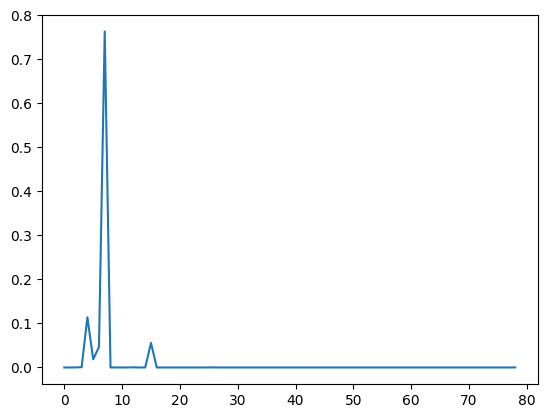

In [ ]:
mod = mod.eval()
x = torch.tensor([[77,  4],
        [77, 15]])
padded_text, l = pad_pack(x)
img_f = mod.encoder(img1)
lat = mod.decoder.encoder(mod.decoder.encoder_dim(img_f))
lat = lat.repeat_interleave(2, dim=0)
pylab.plot(torch.nn.functional.softmax(mod.decoder.decoder(padded_text, res, x_mask=triangle_mask(l).to(device))[:,-1,:].squeeze(dim=1), dim=1)[0].detach().numpy())

<ipython-input-180-6cbd1aafd772>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pylab.plot(torch.nn.functional.softmax(mod.decoder.decoder(padded_text, lat, triangle_mask(l).to(device))[0,-1,:]).detach().numpy())


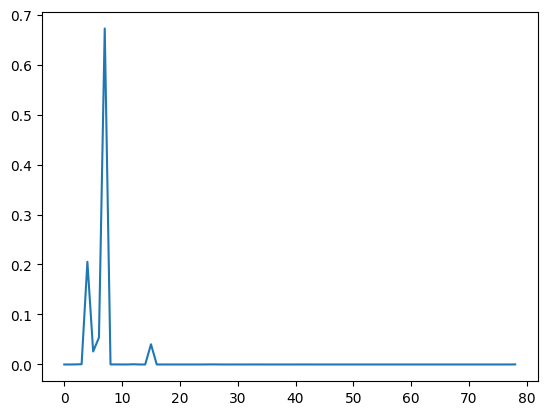

In [ ]:
mod = mod.eval()
x = torch.tensor([[77,  4]])
padded_text, l = pad_pack(x)
img_f = mod.encoder(img1)
lat = mod.decoder.encoder(mod.decoder.encoder_dim(img_f))
lat = lat.repeat_interleave(1, dim=0)
pylab.plot(torch.nn.functional.softmax(mod.decoder.decoder(padded_text, lat, triangle_mask(l).to(device))[0,-1,:]).detach().numpy())

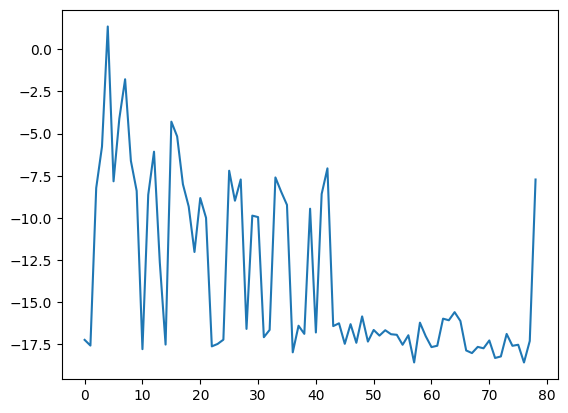

In [ ]:
mod = mod.eval()#same still diff means not batch

x = torch.tensor([[77,5]])
padded_text, l = pad_pack(x)
pylab.plot(mod(img1, padded_text, triangle_mask(l).to(device))[0,-1,:].detach().numpy())

In [ ]:
#not everything combined and top k this way it will always pick all C

<ipython-input-168-5cdc9d4e2c80>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pylab.bar(np_map[np.arange(len(out[0][-1]))],torch.nn.functional.softmax(out[0][-1]/t).cpu().detach().numpy()) #here forget to use -1 but use 0 that is why all same dream miss train


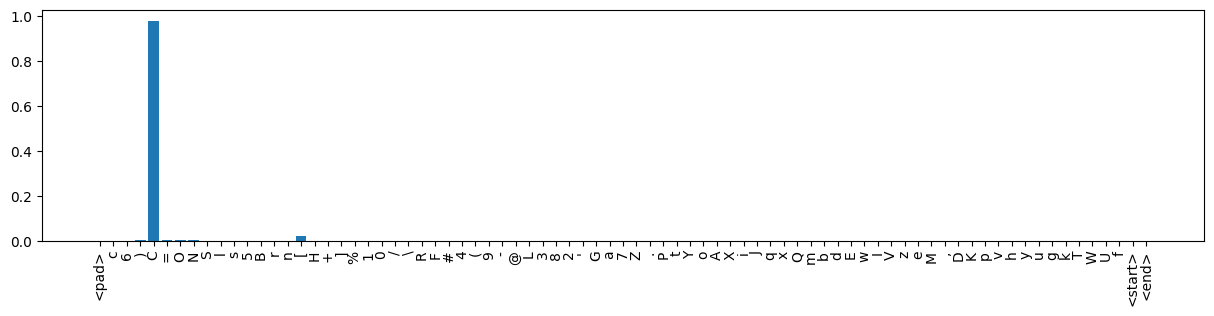

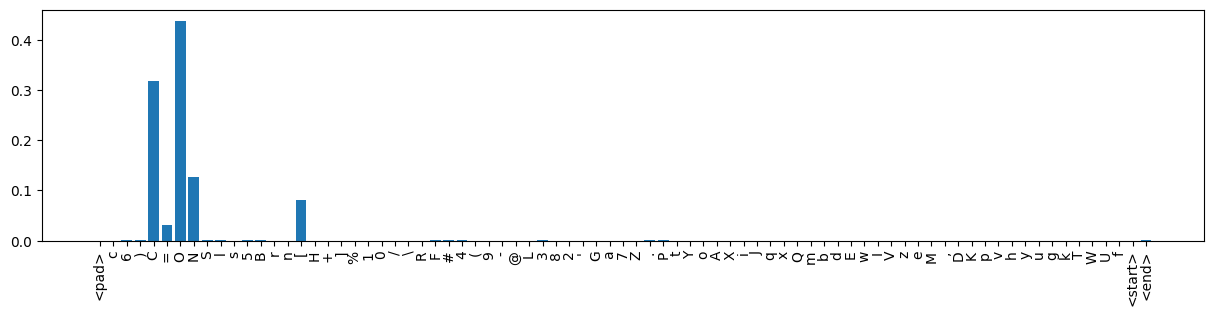

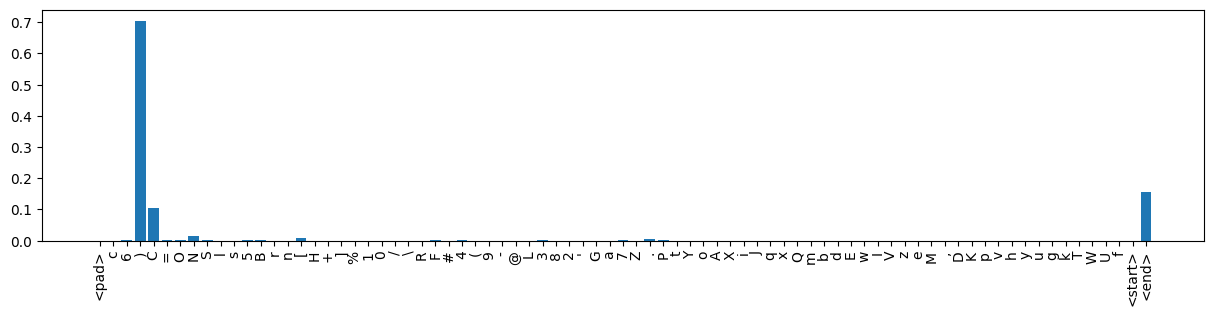

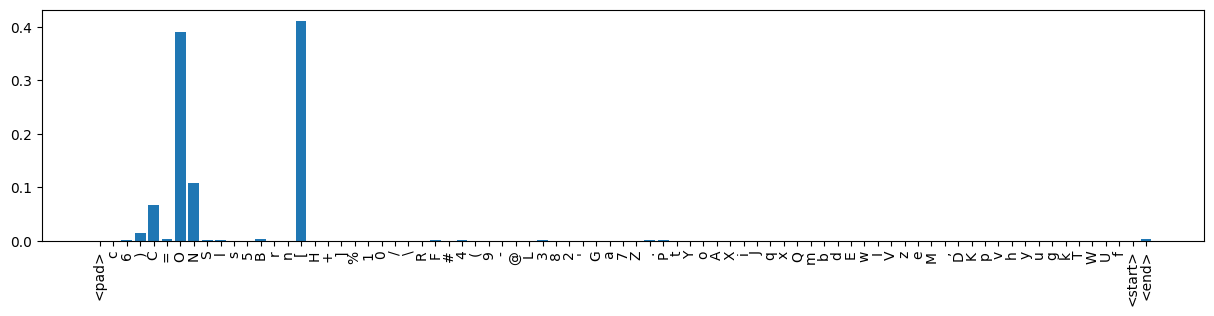

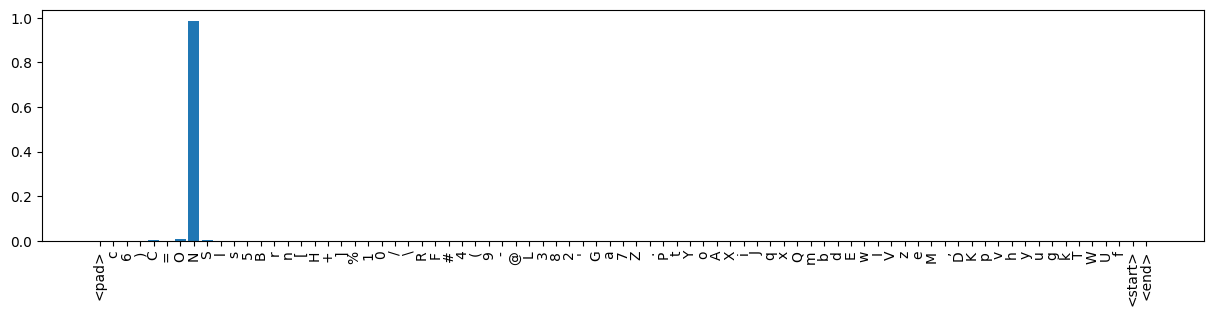

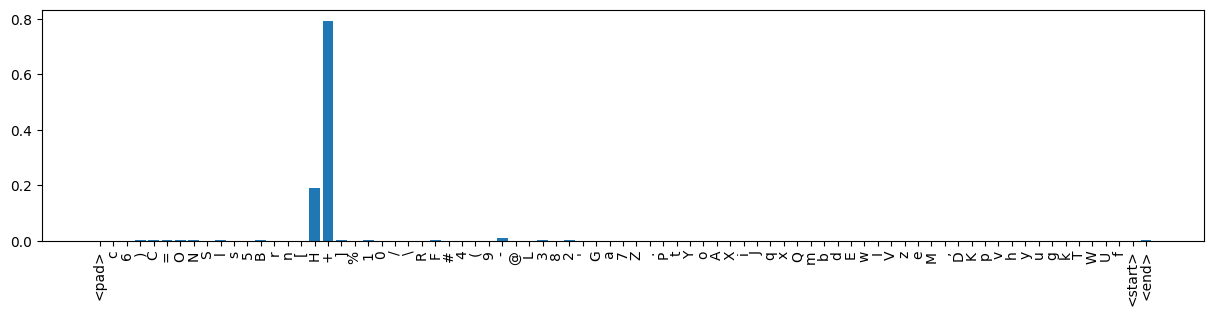

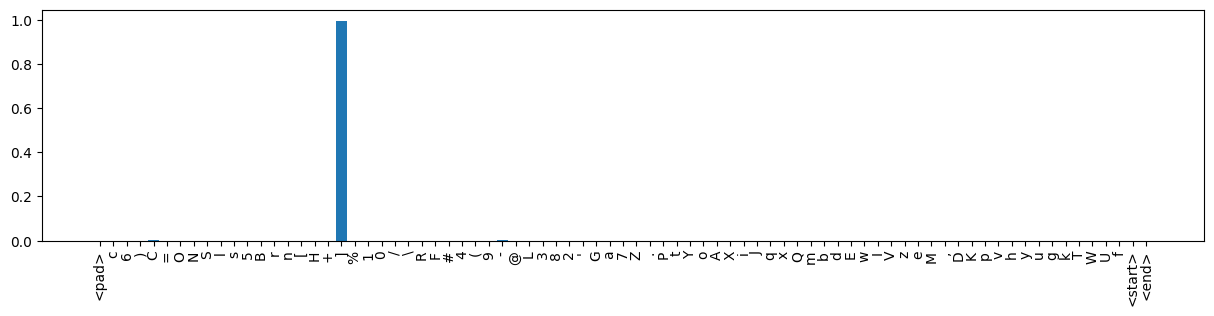

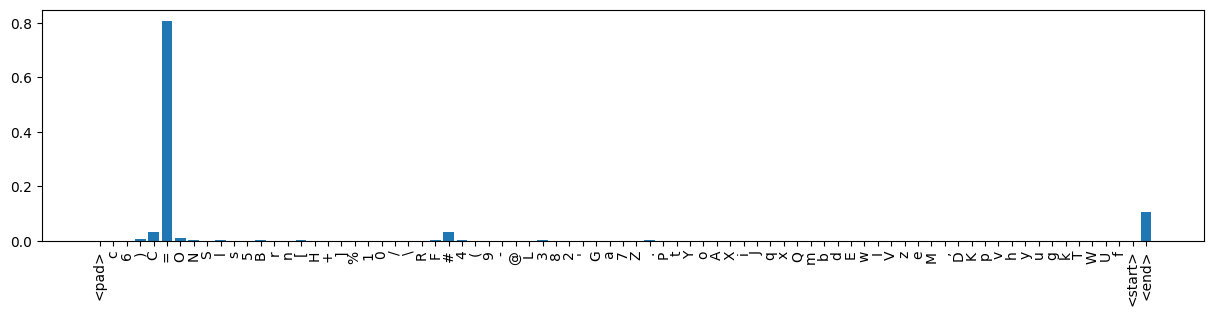

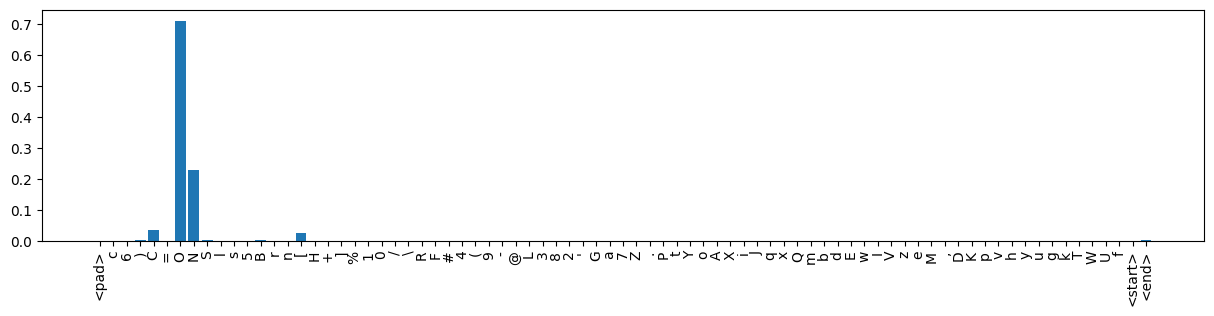

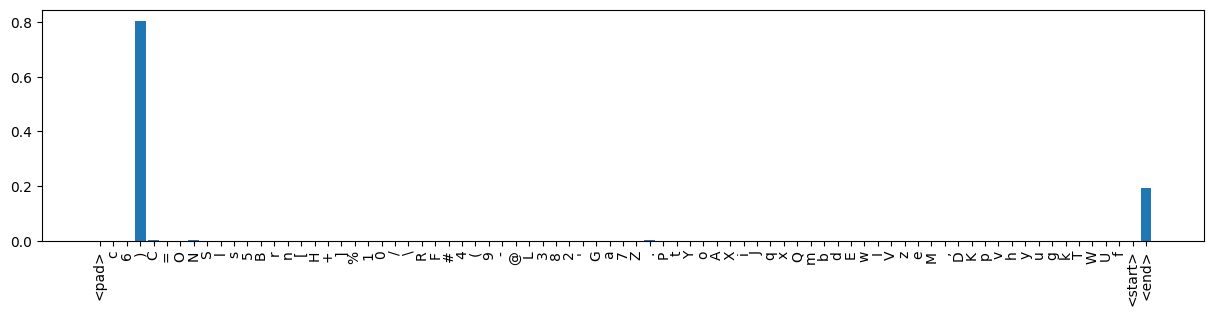

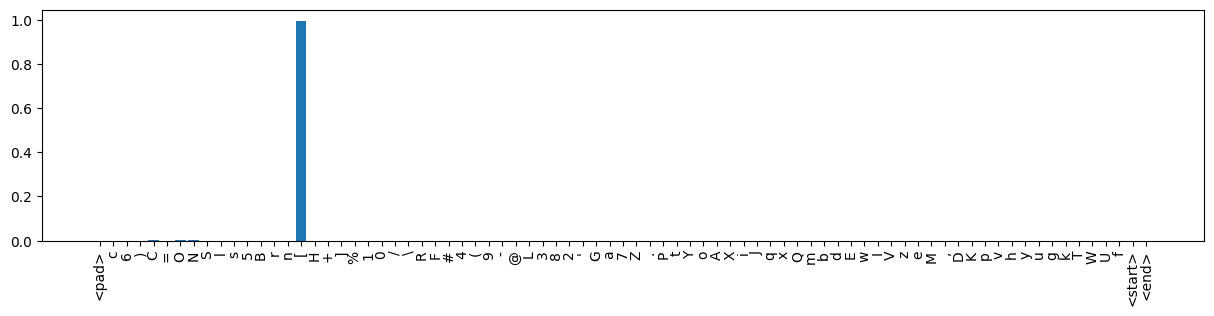

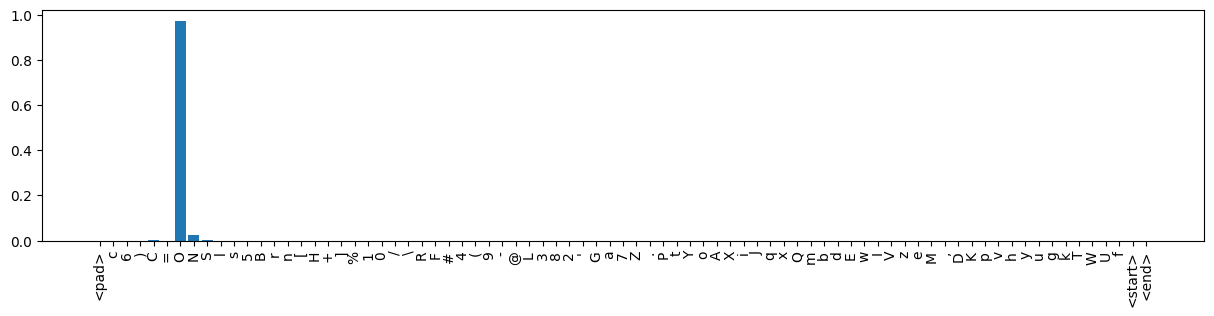

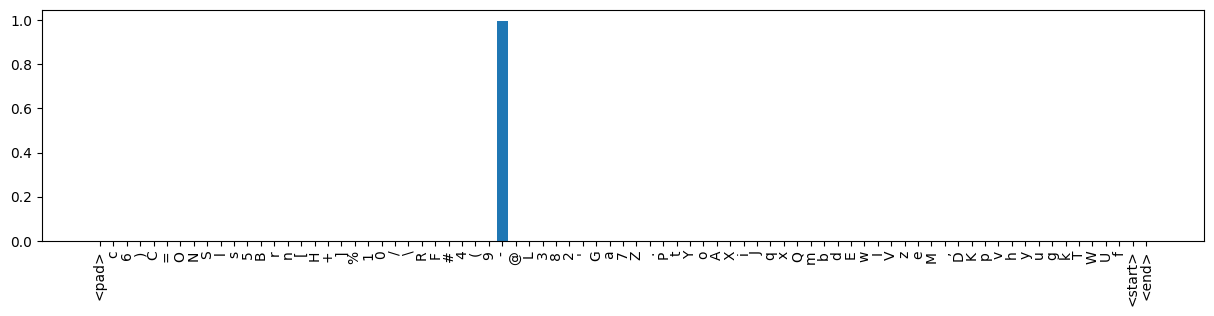

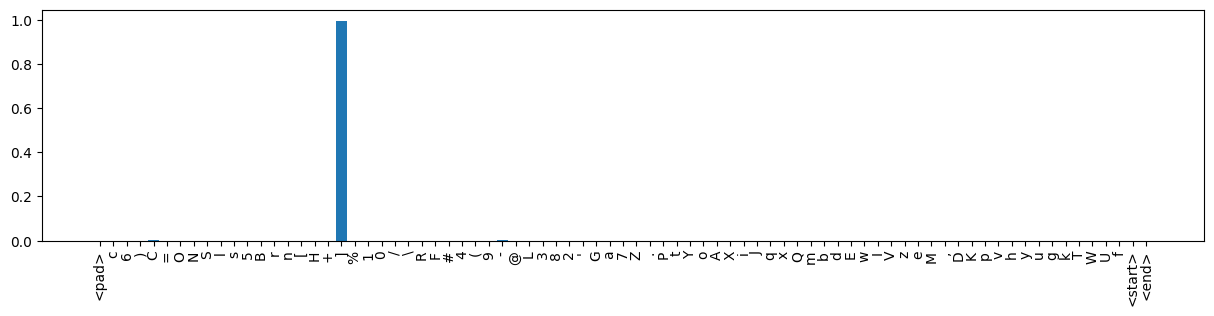

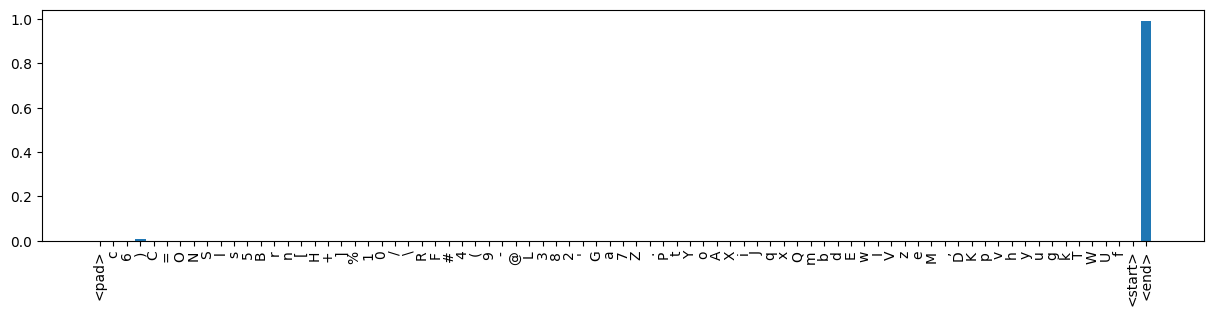

<start>C(O)[N+](=O)[O-]<end>


In [ ]:
# gen.train(False)#why train false jiu zhengquehenduo dengdenggaihuiquyeshia
# kesouhlong zhijie load lai yucejiushi zheyang hlong yuanlai shi meiyou train hao? meiyou chongxingruan gen=? chouwei aaawhy henhuang meiyisi
pylab.rcParams["figure.figsize"] = (15,3)
gen.train(False)
res = gen.forward(torch.tensor(np.array(Image.open("2.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32), [[77]], 100, 1)
for str_ in res:
  print(converter.decode("".join([reversed_word_map_[i] for i in str_])
  ))


In [ ]:
converter.encode("C(N)O")

'CN)O'

In [ ]:
torch.save(mod, "drive/MyDrive/perfect")

In [ ]:
mod = torch.load("drive/MyDrive/CNO")

In [ ]:
image = torch.tensor(np.array(Image.open("c.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)

image = image.to(device)
padded_x = pad_pack([[77]])

xmask = triangle_mask(padded_x[1]).to(device)
text_in = padded_x[0].to(device)

outputs = mod(image, text_in, xmask)

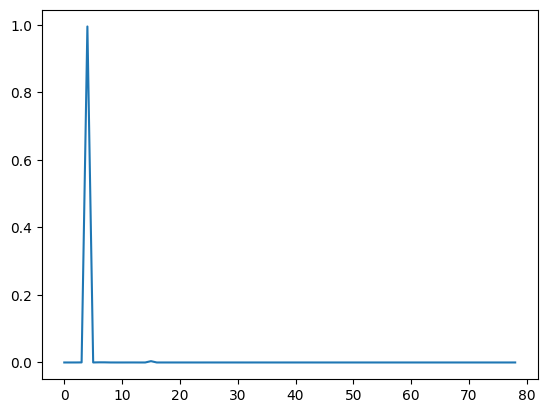

In [ ]:
pylab.plot(torch.nn.Softmax()(outputs[0][0]).cpu().detach().numpy())

In [ ]:
Image.open("d.jpg")

In [ ]:
Image.open("images/a.jpg")

In [ ]:
#for and save aaa GED
train(0.00004, 0.95, 30, 6)


In [ ]:
mod = torch.load("good_one.pt")

In [ ]:
torch.save(mod, "good_one.pt")

In [ ]:
!cp good_one.pt drive/MyDrive/

In [ ]:
!ls -l good_one* -h

-rw-r--r-- 1 root root 155M Feb  1 01:50 good_one.pt


In [ ]:
# 12361!! finallly works bieren kajnw o

In [ ]:
text_in

In [ ]:
pylab.imshow(image[5].permute(1,2,0).cpu()/255)

In [ ]:
pylab.imshow(image[3].permute(1,2,0).cpu()/255)


In [ ]:
train(0.00004, 0.7, 6)
# No black out

In [ ]:
#This time very well how???????
torch.seed()

In [ ]:
res = np.array([i.item() for i in access[350:]])

In [ ]:
np.sum(res==1)/len(res)

In [ ]:
pylab.plot([i.item() for i in access], label="Train")
pylab.plot(np.arange(len(val_acc))*(len(access)/len(val_acc)),val_acc,label="Val")
pylab.legend()

In [ ]:
image.requires_grad_()
outputs = mod(image, text_in, xmask)
loss = loss_fn(outputs, text_out)
loss.backward()

In [ ]:
img = image[0].permute(1,2,0).detach().cpu()
pylab.imshow(img/torch.max(img))

In [ ]:
ans = image.grad[0].permute(1,2,0).cpu()
ans = (ans-torch.mean(ans))/torch.std(ans)
pylab.imshow(torch.sum(((ans)), dim=-1), cmap="gray")

In [ ]:
mod.decoder.layer[0].attn2